In [32]:
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import Bunch

from cogpred.utils.configuration import get_config
config = get_config()


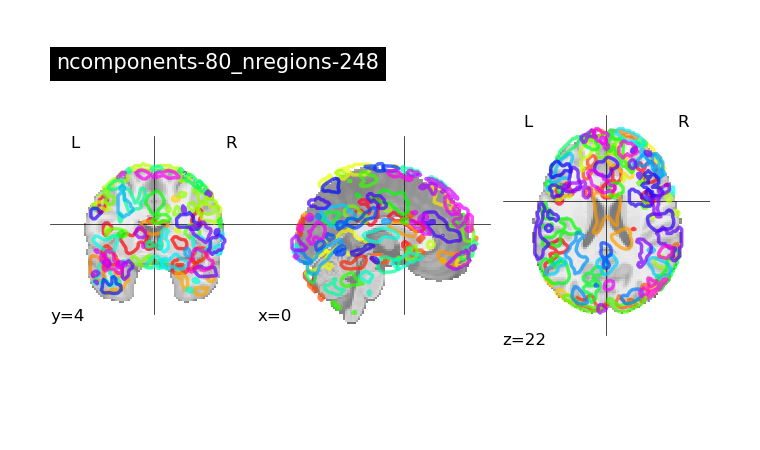

In [33]:
from neuroginius.atlas import Atlas, atlas_mapping

i_path = Path(config["parcellations"]) / "ncomponents-80_nregions-248"
atlas = Atlas.from_path(i_path)
atlas.plot()
plt.show()

In [34]:
source_maps = atlas.maps.get_fdata()
n_regions = source_maps.shape[-1]
target_map = np.zeros(source_maps.shape[:-1])

shape = target_map.shape
BACKGROUND_VALUE = 0

for i in range(shape[0]):
    for j in range(shape[1]):
        for k in range(shape[2]): # I suppose we could get rid of this loop quite easily

            voxel_values = source_maps[i, j, k, :]
            region_index = np.argmax(voxel_values)

            if voxel_values[region_index] == BACKGROUND_VALUE:
                target_map[i, j, k] = BACKGROUND_VALUE
            else:
                target_map[i, j, k] = region_index + 1


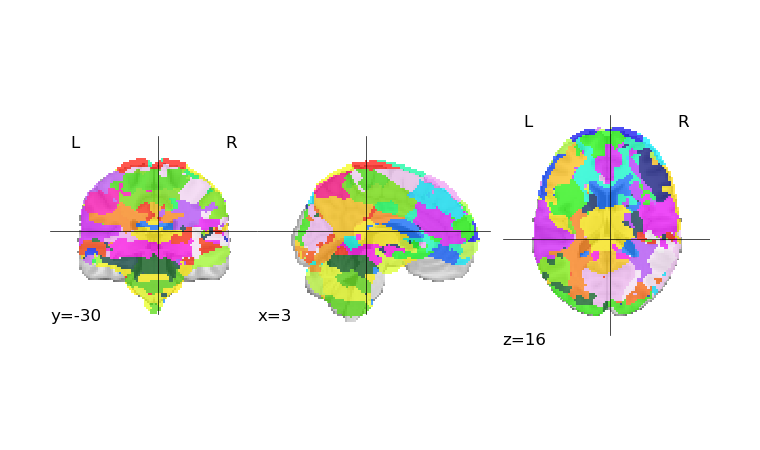

In [35]:
import nibabel as nib
from nilearn.plotting import show, plot_roi

new_maps = nib.nifti1.Nifti1Image(
    target_map,
    affine=atlas.maps.affine
)
nib.save(new_maps, i_path / "hard.nii.gz")
plot_roi(new_maps)
show()


In [3]:
from cogpred.loading import make_training_data

conn_dir = config["connectivity_matrices"]
ATLAS = "msdl" # We don't really care about the atlas
k = 3
_, metadata = make_training_data(conn_dir, ATLAS, k)
func_filename = metadata.sample(n=1, random_state=1234).file_path.values[0]

Dropping 9 subjects because of lacking MMMSE


In [4]:
masker = atlas.fit_masker()
masked = masker.transform_single_imgs(func_filename)

In [7]:
masker.generate_report()

/tmp/ipykernel_1460855/1574612842.py:1: UserWarning: No image provided to fit in NiftiMapsMasker. Plotting only spatial maps for reporting.
  masker.generate_report()


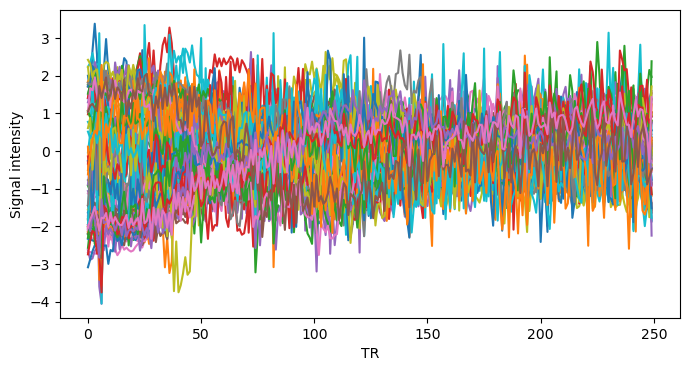

In [5]:
from scipy.stats import zscore
from cogpred.plotting import plot_ts
masked = zscore(masked)
plot_ts(masked)
plt.show()

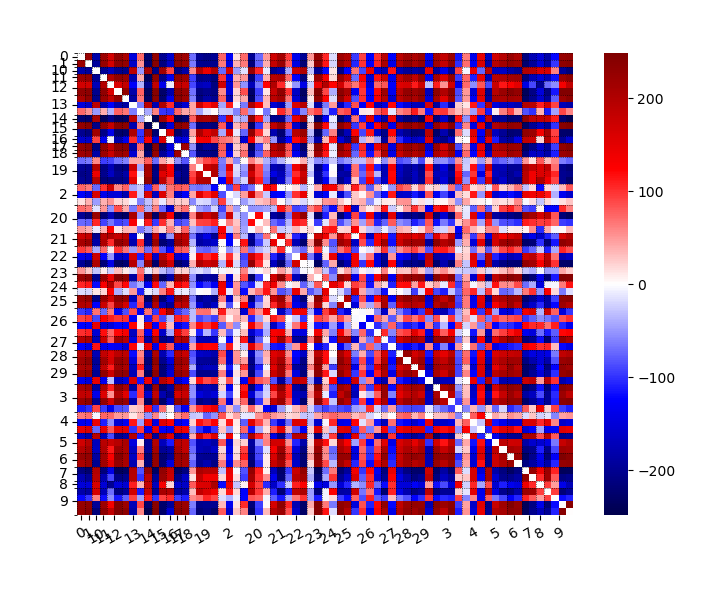

In [6]:
from neuroginius.plotting import plot_matrix
plot_matrix(masked.T @ masked, atlas)
plt.show()